In [1]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# basic imports
import tensorflow as tf 
import os
import numpy as np
import datetime
import tensorflow_hub as hub

from keras.utils import dataset_utils
import matplotlib.pyplot as plt

from IPython import display

import glob
import imageio
import PIL
import tensorflow as tf
import time

import baseline_config

In [2]:
def enforce_memory_limit(mem_mb):
  # enforce memory limit on GPU

  gpus = tf.config.experimental.list_physical_devices('GPU')
  if gpus:
    try:
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=mem_mb)])
      print(f"vram limit set to {mem_mb}MB")
    except RuntimeError as e:
      print(e)
      
# enforce max 5 GB memory on GPU for this notebook
# enforce_memory_limit(5120)

In [3]:
########################################################################################
# MODEL PARAMETERS
########################################################################################
MODEL_INPUT_IMAGE_WIDTH = 256
MODEL_INPUT_IMAGE_HEIGHT = 256
MODEL_INPUT_IMAGE_CHANNELS = 3

In [4]:
def paths_and_labels_to_dataset(image_paths,labels,num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    img_ds = path_ds.map(
        lambda path: tf.io.read_file(path), 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    img_ds = tf.data.Dataset.zip((img_ds, label_ds))
    return img_ds

def create_dataset(subset):
    image_paths, labels, class_names = dataset_utils.index_directory(
            baseline_config.dataset_path + subset,
            labels="inferred",
            formats=('.pt'),
            class_names=None,
            shuffle=False,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=image_paths,
        labels=labels,
        num_classes=len(class_names))
    
    return dataset, class_names

train_dataset, class_names = create_dataset('TRAIN/')
test_dataset, _            = create_dataset('TEST/')
validation_dataset, _      = create_dataset('VALIDATION/')
print("class names: ", class_names)

Found 12384 files belonging to 5 classes.
Found 54 files belonging to 5 classes.
Found 817 files belonging to 5 classes.
class names:  ['brant', 'jabwar', 'sheowl', 'spodov', 'wiltur']


In [5]:

def dataset_transforms(image,label):
    # reshape into standard 3 channels
    image = tf.io.parse_tensor(image, tf.float32)
    image = tf.expand_dims(image, -1)
    
    # most pre-trained model expect 3 color channels
    image = tf.repeat(image, MODEL_INPUT_IMAGE_CHANNELS, axis=2)
    
    image = tf.ensure_shape(image, [216, 128, MODEL_INPUT_IMAGE_CHANNELS])
    image = tf.image.resize(image, (MODEL_INPUT_IMAGE_WIDTH,MODEL_INPUT_IMAGE_HEIGHT), 
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # for some reason the melspecs seem rotated by 90 degrees. This corrects that.
    image = tf.image.rot90(image, k=1)
    
    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / tf.reduce_max(image)
    
    return image,label

train_dataset_b = ( 
                  train_dataset       
                  .shuffle(20000)
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)
                  .cache()           
                )

validation_dataset_b = ( 
                  validation_dataset
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)
                  .cache()
                )

test_dataset_b = ( 
                  test_dataset
                  .map(dataset_transforms)
                  .batch(baseline_config.batch_size)
                  .cache()
                )

 item and label shapes (64, 256, 256, 3) , (64, 5)
 min and max pixel value 0.0, 1.0


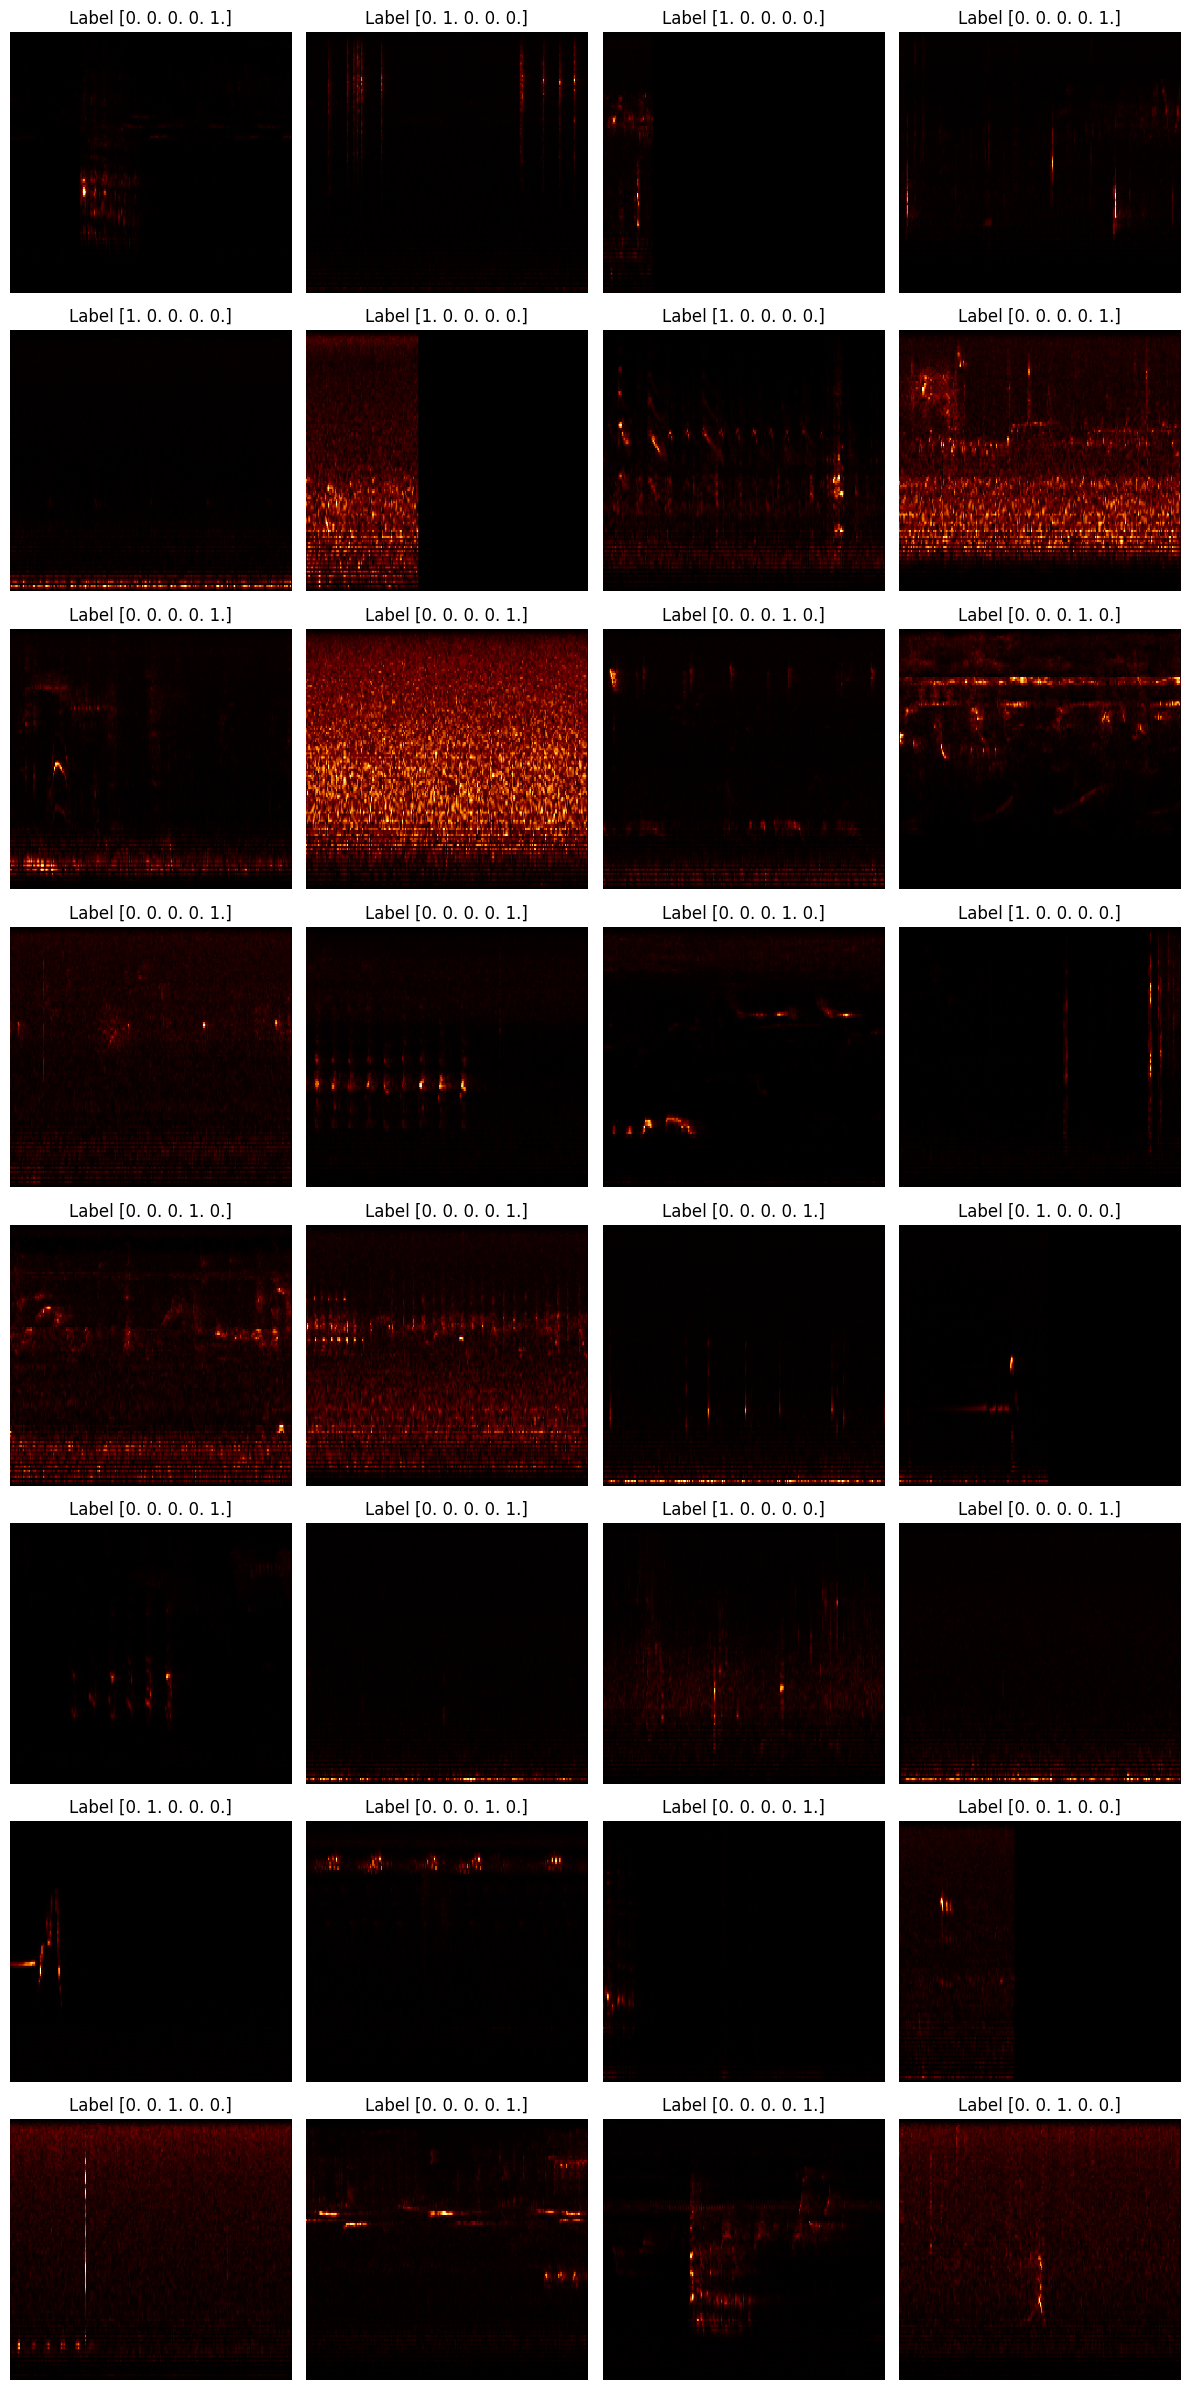

In [6]:
# take 1 batch worth of data from the dataset
for item,lbl in train_dataset_b.take(1):
    print(f' item and label shapes {item.shape} , {lbl.shape}')
    print(f' min and max pixel value {np.min(item)}, {np.max(item)}')
    
    grid_size = (8, 4)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 24))
    
    # lets look at what the batch contains
    b = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            melspec = item[b,:,:,0]
            ax = axes[i, j]
            plot_index = i * grid_size[1] + j
            ax.imshow(melspec, cmap='afmhot', aspect='auto')
            ax.set_title(f'Label {lbl[b,:]}')
            ax.axis('off')
            b = b + 1
            
    plt.tight_layout()
    plt.show()

In [7]:
# code derived from https://www.tensorflow.org/tutorials/generative/cvae

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    
    super(CVAE, self).__init__()
    
    self.latent_dim = latent_dim
    
    # this encodes the melspectrogram into a latent space 'z'
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=7, strides=(2, 2), activation='relu'),
            # tf.keras.layers.Conv2D(
            #     filters=64, kernel_size=5, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=5, strides=(2, 2), activation='relu'),                     
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    # this decodes the latent space 'z' back into the original melspectrogram
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=32*32*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(32, 32, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=7, strides=2, padding='same',
                activation='relu'),
            # tf.keras.layers.Conv2DTranspose(
            #     filters=64, kernel_size=5, strides=2, padding='same',
            #     activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=5, strides=2, padding='same',
                activation='relu'),            
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )
    
    # adding class information to make this semi-supervised
    self.classifier = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            
            # hidden layers
            tf.keras.layers.Dense(units=64, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=32, activation=tf.nn.relu),
            
            # output layer
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(units=len(class_names), activation=None),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [8]:
latent_dim = 2
epochs = 100

optimizer = tf.keras.optimizers.Adam(1e-5)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x, y):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  x_class = model.classifier(z)
  
  class_ent = tf.nn.softmax_cross_entropy_with_logits(y, x_class)
  # print(class_ent)
  
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  
  c1 = 0 # -0.0002*tf.reduce_mean(logpx_z + logpz - logqz_x)
  c2 = 0.999*tf.reduce_mean(class_ent)
  
  # test against built in loss function (should be same number)
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  c3 = loss(y, x_class)
  
  print(f' loss components: {c1} {c2} {c3}')
  
  return c1+c2

@tf.function
def train_step(model, x, y, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, y)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
model = CVAE(latent_dim)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x,target_y in train_dataset_b.take(50):
    for b in range(train_x.shape[0]):
      train_step(model, train_x, target_y, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x,target_y in validation_dataset_b.take(20):
    loss(compute_loss(model, val_x, target_y))
  val_loss = loss.result()
  print('Epoch: {}, Validation loss: {}, time elapse for current epoch: {}'
        .format(epoch, val_loss, end_time - start_time))

 loss components: 0 Tensor("mul_6:0", shape=(), dtype=float32) Tensor("categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 loss components: 0 Tensor("mul_6:0", shape=(), dtype=float32) Tensor("categorical_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 loss components: 0 0.5758544206619263 0.5764308571815491
 loss components: 0 0.5375995635986328 0.538137674331665
 loss components: 0 1.6951879262924194 1.6968847513198853
 loss components: 0 1.4988692998886108 1.500369668006897
 loss components: 0 3.5031700134277344 3.50667667388916
 loss components: 0 1.755576252937317 1.757333517074585
 loss components: 0 1.590902328491211 1.5924948453903198
 loss components: 0 1.8452328443527222 1.847079873085022
 loss components: 0 12.075263023376465 12.087349891662598
 loss components: 0 1.171830177307129 1.1730031967163086
 loss components: 0 3.0988521575927734 3.1019539833068848
 loss components: 0 3.99088716506958 3.994882106781006
 loss components: 0 2.0907

In [ ]:
def build_model(trainable):
    # build a really simple classification model using a pre-training Efficientnet V2
    model = tf.keras.Sequential(
        [
            # input layer
            tf.keras.layers.InputLayer(input_shape=(MODEL_INPUT_IMAGE_WIDTH,MODEL_INPUT_IMAGE_HEIGHT,3)),
  
            # use the model as a feature generator only
            # use pre-trained mobilenet v2 as the feature layer (less parameters, more accessible)
            # hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", trainable),  
            
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2", trainable), 
            
            # much larger model to see if more parameters matters...
            #hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5", trainable),  
                        
            # add the classification layer here       
            tf.keras.layers.Flatten(), 
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dense(len(class_names)*30, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dense(len(class_names)*20, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dropout(0.50),
            tf.keras.layers.Dense(len(class_names)*1, activation=None),
        ]
    )
    # need to tell the model what the input shape is
    model.build([None, 
                 MODEL_INPUT_IMAGE_HEIGHT,
                 MODEL_INPUT_IMAGE_WIDTH, 
                 MODEL_INPUT_IMAGE_CHANNELS])

    # show the model
    model.summary()
    
    return model

In [ ]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
# allow all the weights to be trained
model = build_model(True)

# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.5,
                                                      patience=4, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-8)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_cnn_model.hdf5', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# fit the model to the training set
model.fit(train_dataset_b, 
          validation_data=validation_dataset_b,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=1000)

In [ ]:
# save the model weights
model.save_weights('models/baseline_cnn_model.hdf5', save_format='h5')

# test load the model for inference
test_model = build_model(False)
test_model.build([None, 
                MODEL_INPUT_IMAGE_HEIGHT,
                MODEL_INPUT_IMAGE_WIDTH, 
                MODEL_INPUT_IMAGE_CHANNELS])
test_model.load_weights('models/baseline_cnn_model.hdf5')